# CS-UY 3943 - Introduction of Data Science
## Week 9: Classification II

Please edit the cell below to add your name, NetID, assigned group, and group members for this assignment. **Complete this section before proceeding to the assignment questions.**

Name: Mateo Castro
NetID: mc7212
Group (Letter): F
Group Member 1: Abed
Group Member 2: David
***

This assignment will continue where we left off from our last session. Again, we will be analyzing data generated by particle physicists to test whether machine learning can help classify certain particle decay experiments to identify the presence of a Higgs Boson. However, rather than using default parameter values for the classification models, we will instead use cross-validation for model selection. 

### Part 1: ROC AND AUC
In this part, you will generate ROC curves for your out-of-the box logistic regression (LR) and support vector machine (SVM) models. Out-of-the-box means that you build models without parameter tuning. 

1. Clean the two data files for this assignment (**boson_training_cut.csv** and **boson_testing_cut.csv**) as before and use them as training and testing data sets, respectively.

In [40]:
import pandas as pd
import numpy as np

def clean_boson_data(infile_name):
    df = pd.read_csv(infile_name)

    df = pd.get_dummies(df, drop_first=True)
    df.rename(columns={'Label_s' : 'Y'}, inplace=True)
    df = df.set_index('EventId')
    
    df[df == -999] = np.nan
    for col in df:
        if(col == 'EventId' or col == 'Y'):
            continue
        
        df[col].fillna(np.mean(df[col]), inplace=True)
        
        df[col] = (df[col] - np.mean(df[col])) / np.std(df[col])
                
    return df

df_train = clean_boson_data('boson_training_cut.csv')
df_test = clean_boson_data('boson_testing_cut.csv')

In [41]:
df_train.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,Y
EventId,,,,,,,,,,
100000,3.983624e-01,0.092601,0.491173,-0.444021,-1.650125e+00,-1.135322e+00,1.873193e+00,0.888048,1.120050,1
100001,8.633960e-01,0.608117,0.639363,-0.120744,-1.941583e-14,1.672027e-14,-4.795839e-15,1.421917,-0.806390,0
100002,-2.059005e-14,3.421843,1.261884,-0.321306,-1.941583e-14,1.672027e-14,-4.795839e-15,0.997693,-0.455521,0
100003,5.108589e-01,0.989159,0.028516,-0.885926,-1.941583e-14,1.672027e-14,-4.795839e-15,1.209152,-0.886831,0
100004,1.172363e+00,-0.953916,1.504447,-0.629578,-1.941583e-14,1.672027e-14,-4.795839e-15,1.967534,-0.113790,0


In [42]:
df_test.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,Y
EventId,,,,,,,,,,
300000,-1.213348e-01,1.455304,0.099593,-0.447028,-1.862346e-12,1.412368e-13,1.724853e-13,0.007415,0.498029,0
300001,-1.067373e+00,-0.715757,-0.854408,-0.103307,-1.862346e-12,1.412368e-13,1.724853e-13,-0.758743,1.730043,0
300002,-1.159847e-01,0.480365,0.064286,-0.297389,-2.874836e-01,6.645349e-01,-7.332925e-02,0.465570,0.505136,1
300003,8.355185e-01,0.476970,0.482975,-0.882260,-1.862346e-12,1.412368e-13,1.724853e-13,1.416531,-0.804583,0
300004,2.997757e-13,0.925326,-0.484386,-0.473912,-1.862346e-12,1.412368e-13,1.724853e-13,-0.195354,0.417565,0


2. Using the training set, build the following models:

* A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
* An SVM using sklearn's `svm.SVC()`. For this model, use `kernel="linear"`.

For each model, plot the ROC curve. Include the ROC curves on the same plot. Use the `decision_function()` method for each classifier to compute the target scores needed to compute the ROC curve. Make sure to use the test dataset for computing and plotting. In the legend, also include the Area Under the ROC Curve (AUC) for each classifier for reference.

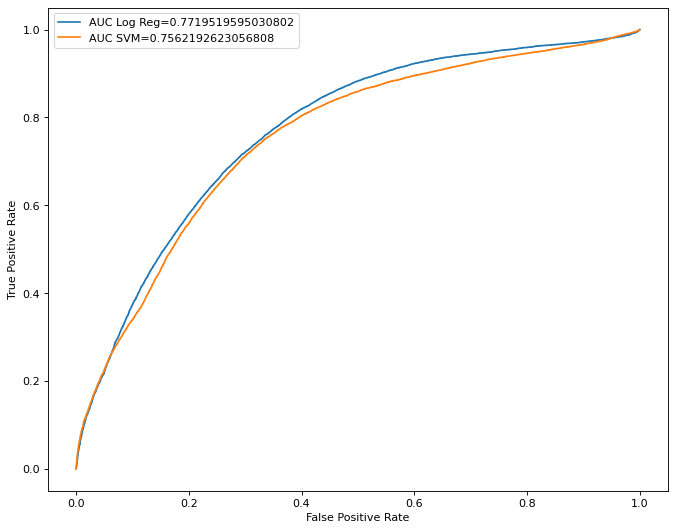

In [85]:
import matplotlib.pyplot as plt
from sklearn import svm, linear_model, metrics
%matplotlib inline

# Data
train_X = df_train.iloc[:,:-1]
train_y = df_train['Y']

test_X = df_test.iloc[:,:-1]
test_y = df_test['Y']

# Logistic Regression
lr = linear_model.LogisticRegression(C=1e30)

lr.fit(train_X, train_y)

y_pred_lr = lr.decision_function(test_X)

fpr_lr, tpr_lr, _ = metrics.roc_curve(test_y,  y_pred_lr)
auc_lr = metrics.roc_auc_score(test_y, y_pred_lr)

# SVM
sv = svm.SVC(kernel="linear")

sv.fit(train_X, train_y)

y_pred_svm = sv.decision_function(test_X)

fpr_svm, tpr_svm, _ = metrics.roc_curve(test_y,  y_pred_svm)
auc_svm = metrics.roc_auc_score(test_y, y_pred_svm)

# Plotting
plt.figure(figsize=(10, 8), dpi=80)

plt.plot(fpr_lr,tpr_lr,label="AUC Log Reg="+str(auc_lr))
plt.plot(fpr_svm,tpr_svm,label="AUC SVM="+str(auc_svm))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend()
plt.show()

3. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)? (HINT: You may want to increase the size of your plot above to more clearly see its contents).

<p>
<span style="color:blue">
Logistic regression is generally better at ranking the test set. There are no classification thresholds where the logisitc regression model would underperfrom the svm in a classification metric. 
</span>
</p>

### Part 2: A homemade cross-validation function
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  We will use cross-validation to find the optimal $C$.

1\. Write a cross-validation function (do not use any pre-existing cross-validation tools such as those defined in `sklearn.model_selection`):
- Takes as inputs a dataset, a label name (the column with target values), # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Randomly shuffles the data
- Splits the data into `k` approximately equal sized groups (folds)
- Performs two loops
  - Outer Loop (iterate over folds to determine which to hold out as test data):
    - Splits the data into `data_train` & `data_test` according to cross-validation logic
  - Inner Loop: (iterate over $C$ values with each $C$ used to build a different classifier:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_\<C\>_\<FOLD_ID\> on validation data (FOLD_ID_ corresponds to the hold-out fold)
    - Stores AUC_\<C\>_\<FOLD_ID\> in a dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]` (*c* is the chosen value for $C$ and the integer is the *FOLD_ID*)

In [88]:
def cross_val_svm(dataset, label_name, k, cs):
    aucs={}
    
    for c in cs:
        aucs[c] = []
    
    df = dataset.sample(frac=1)
    fold_size = len(dataset)//k
    
    for i in range(k):
        data_train = dataset.iloc[fold_size * i : fold_size * (i+1), :]
        test1 = dataset.iloc[0 : fold_size * i, :]
        test2 = dataset.iloc[fold_size * (i+1) : -1, :]
        data_test = pd.concat([test1, test2])
        
        for c in cs:
            sv = svm.SVC(C=c, kernel="linear")
            
            train_X = data_train.drop(label_name, axis=1)
            train_y = data_train[label_name]

            test_X = data_test.drop(label_name, axis=1)
            test_y = data_test[label_name]
            
            sv.fit(train_X, train_y)
            y_pred= sv.decision_function(test_X)

            auc = metrics.roc_auc_score(test_y, y_pred)
            
            aucs[c].append(auc)
    return aucs

In [89]:
cross_val_svm(df_train, 'Y', 5, [.1, 1, 10])

{0.1: [0.7268009454321241,
  0.7487271436179656,
  0.7474345250838508,
  0.6864313893623862,
  0.7310288094654672],
 1: [0.7333760927572387,
  0.7511130836144151,
  0.7443820024263185,
  0.6877677469322555,
  0.7386022333461687],
 10: [0.7329384583219642,
  0.7508521214273034,
  0.74421786912153,
  0.6877539165822439,
  0.7373455385584765]}